# Mixture Models and E-M

## Latent Variable Models
blah blah latent

### Advantages of LVMs
1. Using a small number of latent variables can lead to fewer free parameters (coefficients) in the learner.
2. The latent variables can form a compressed representation (bottleneck) of the features.


## Mixture Models

##### Latent variables
For this example, let the latent variables be discrete: $z_i \in \{1,...,K\}$.

##### Priors
The priors on the latent variables are just a categorical distribution $p(z_i) = Cat(\pi)$. Note that this models the latent variables in a one-hot encoding fashion, which can be limiting. The family of Factor Analysis methods expands on this to model the ${z_i}$ more generally than $Cat(\pi)$.

##### Likelihood
The likelihood of the data, conditioned on the observed latent variable, is $p(x_i|z_i=k) = p_k(x_i)$. The second notation emphasizes how the likelihood can be considered to be k different distributions, where the priors on the latent variables act as weights defining the contribution of each distribution.

##### The Mixture Model
The mixture model is then defined as follows:

$$
\begin{align}
    p(x_i|\theta) &= \sum_{k=1}^K p(x_i,z_i=k|\theta) \\
                  &= \sum_{k=1}^K p(z_i=k) p(x_i|z_i=k, \theta) \\
\end{align}
$$

This is a convex combination of the priors (weights) and likelihoods (basis elements). It is called a mixture model because we are _mixing_ together the $K$ likelihoods to form the overall likelihood representation.


### Gaussian Mixture Models (GMMs)
The most popular mixture models are GMMs. Here, the likelihood distributions $p(x_i|z_j = k)$ are Gaussians, each with mean vector $\mu_k$ and covariance matrix $\Sigma_k$.

$$\begin{align}
    p(x_i|\theta) &= \sum_{k=1}^K p(z_i=k) p(x_i|z_i=k,\theta) \\
                  &= \sum_{k=1}^K p(z_i=k) N(x_i|\mu_k,\Sigma_k)
\end{align}$$

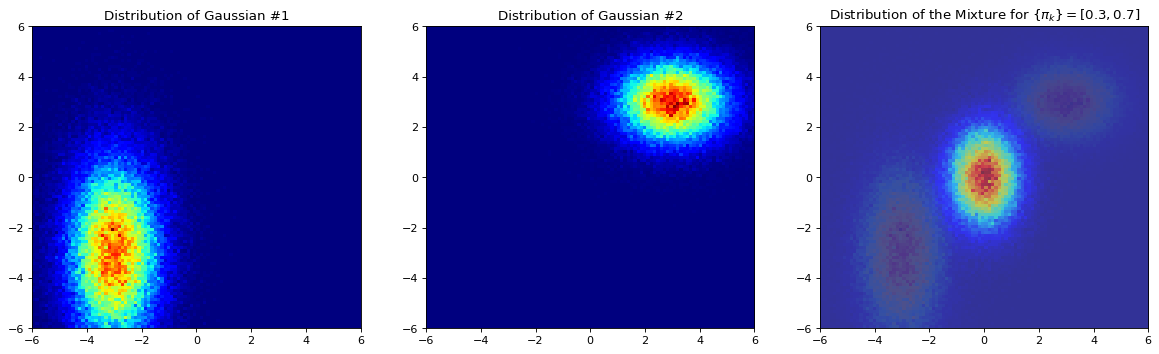

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import matplotlib
import seaborn as sns
from numpy import eye, dot, diag
from numpy.random import multivariate_normal as mvn

matplotlib.rcParams['figure.figsize'] = [10, 10]

%matplotlib inline

N = int(1e5)
hist_bins = (100, 100)  # more bins for finer-grain resolution
axes = [[-6, 6], [-6, 6]]

# define the individual Gaussian distributions
gaussian_1 = mvn([-3, -3], eye(2).dot(diag([1, 5])), N)
gaussian_2 = mvn([3, 3], eye(2).dot(diag([1.5, 1])), N)
gaussian_mixture = 0.5 * gaussian_1 + 0.5 * gaussian_2
    
fig = plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(1, 3, 1)
_ = ax.hist2d(gaussian_1[:, 0], gaussian_1[:, 1], bins=hist_bins, range=axes, cmap=plt.cm.jet)
_ = plt.title("Distribution of Gaussian #1")

ax = fig.add_subplot(1, 3, 2)
_ = ax.hist2d(gaussian_2[:, 0], gaussian_2[:, 1], bins=hist_bins, range=axes, cmap=plt.cm.jet)
_ = plt.title("Distribution of Gaussian #2")

ax = fig.add_subplot(1, 3, 3)
ax.hist2d(gaussian_2[:, 0], gaussian_2[:, 1], bins=hist_bins, range=axes, cmap=plt.cm.jet, alpha=0.3)
ax.hist2d(gaussian_1[:, 0], gaussian_1[:, 1], bins=hist_bins, range=axes, cmap=plt.cm.jet, alpha=0.3)
ax.hist2d(gaussian_mixture[:, 0], gaussian_mixture[:, 1], bins=hist_bins, range=axes, cmap=plt.cm.jet, alpha=0.6)
_ = plt.title(r"Distribution of the Mixture for $\{\pi_k\}=[0.3, 0.7]$")

# E-M Fitting
One approach for fitting the parameters of a mixture model would be to use a gradient decent algorithm to minimize the negative log-likelihood of the mixture: $-log\{p(x|\theta\}$. However, you then usually will need to put several constraints on top of this optimization, such as the weights summing to one and the covariances matrices being positive semi-definite. In the expectation-maximization method, you get these guarantees "for free."

### The dilemma
The dilemma of fitting a mixture distribution is two parts:
1. If we knew the parameters of the individual distributions, it would be straight-foward to determine the mixing coefficients of the mixture model.
2. If we knew the mixing coefficients, it would be straight-forward to estimate the parameters of the individual distributions.

### The brief solution
The E-M method works by alternating back and forth between computing the expectation of the mixing coefficients and maximizing the data log-likelihood according to that expectation.

1. The "E" step (expectation) computes the expectation of the contribution of each distribution to each sample, according to the current parameter estimates of the individual distributions.
2. The "M" step (maximization) estimates the parameters of the individual distributions (the ML or MAP estimate), according to the current expectation computed in the "E" step.

### A little more detail
What we really would like to do is maximize the log-likelihood of the complete data: $l_c(\theta) = \sum_{i=1}^N log\ p(x_i,z_i|\theta)$. Since the ${z_i}$ are latent/unobserved, we cannot compute this quantity. Instead, we resolve to compute our *expectation* of the quantity, conditioned on 1) the observed data and 2) the parameters of the most recent E-M iteration.

This expectation computation is the "E" step, and $Q(\theta,\theta^{t-1})$ is called the *auxiliary function*.

$$
\begin{align}
    Q(\theta,\theta^{t-1}) = E[l_c(\theta)|D,\theta^{t-1}]
\end{align}
$$

The "M" step is then to maximize $Q$ given the current expectation of the latent variables:

$$
\begin{align}
    \theta^{t} = max_{\theta}\ Q(\theta,\theta^{t-1})
\end{align}
$$



### E-M for Gaussian Mixtures
First, we define $Q(\theta)$ for a Gaussian mixture:

$$
\begin{align}
    Q(\theta, \theta^{t-1}) &= E \left[ l_c(\theta)|D, \theta^{t-1} \right] \\
                            &= E \left[ \sum_{i=1}^N log\ p(x_i,z_i|\theta) \right] \\
                            &= \sum_{i=1}^N E \left[ log\left[ \prod_{k=1}^K {(\pi_k p(x_i|\theta_k))}^{I(z_i=k)} \right] \right] \\
                            &= \sum_{i=1}^N E \left[ \sum_{k=1}^K I(z_i=k) log \left[\pi_k p(x_i|\theta_k)\right] \right] \\
                            &= \sum_{i=1}^N \sum_{k=1}^K E \left[ I(z_i=k) \right] log \left[ \pi_k p(x_i|\theta_k) \right] \\
                            &= \sum_{i=1}^N \sum_{k=1}^K p(z_i=k|x_i,\theta^{t-1})\ log \left[ \pi_k p(x_i|\theta_k) \right] \\
                            &= \sum_{i=1}^N \sum_{k=1}^K r_{ik}\ log \left[ \pi_k p(x_i|\theta_k) \right] \\
                            &= \sum_{i=1}^N \sum_{k=1}^K r_{ik}\ \left( log \pi_k + log\ p(x_i|\theta_k) \right) \\
                            &= \sum_{i=1}^N \sum_{k=1}^K r_{ik} log \pi_k + r_{ik} log\ p(x_i|\theta_k) \\
\end{align}
$$

We introduced a new variable here, $r_{ik}$, which is the "responsibility" that distribution $k$ plays for data sample $i$.

### E step for Gaussian Mixtures
The E step computes the $\{r_{ik}\}$ factors:

$$
\begin{align}
    r_{ik} = p(z_i=k|x_i,\theta^{t}) &= \frac {p(z_i=k,x_i|\theta_k^{t-1})} {\sum_{j=1}^K p(z_i=j,x_i|\theta_k^{t-1})} \\
                                     &= \frac {p(z_i=k)p(x_i|\theta_k^{t-1})} {\sum_{j=1}^K p(z_i=j)p(x_i|\theta_k^{t-1})} \\
                                     &= \frac {p(z_i=k)N(x_i|\mu_k,\Sigma_k)} {\sum_{j=1}^K p(z_i=j)N(x_i|\mu_j,\Sigma_j)} \\
\end{align}
$$

### M step for Gaussian Mixtures
The M step updates the estimates for $\{p(z_k), \mu_k, \Sigma_k\}$.

The new estimate for $p(z_k)$ is obtained by maximizing the auxiliary function (the expected log likelihood) with respect to $\pi_k$:

\begin{align}
    0 &= \frac {d} {d\ \pi_k} Q(\theta^t|\theta^{t-1}) \\
      &= \frac {d} {d\ \pi_k} \left\{ \sum_{i=1}^N \sum_{k=1}^K r_{ik} log \pi_k + r_{ik} log\ p(x_i|\theta_k) \right\} \\
      &= \sum_{i=1}^N \frac {r_{ik}} {\pi_k} \\
\end{align}

Note how the solution to this is a critical point of $\pi_k = 0$. This is because the maximization did not place any constraints on the ${\pi_k}$. What we are missing is the sum-to-1 constraint $\sum_{k=1}^K \pi_k = 1$. We can achieve this by introducing a Lagrangian multiplier:

$$
\begin{align}
    0 &= \frac {d} {d\ \pi_k} Q(\theta^t|\theta^{t-1}) + \lambda (\sum_{k=1}^K \pi_k - 1) \\
             &= \frac {d} {d\ \pi_k} \left\{ \sum_{i=1}^N \sum_{k=1}^K r_{ik} log \pi_k + r_{ik} log\ p(x_i|\theta_k)  + \lambda (\sum_{k=1}^K \pi_k - 1) \right\} \\
             &= \sum_{i=1}^N \frac {r_{ik}} {\pi_k} + \lambda \\
             &=> \pi_k = - \frac {r_{ik}} \lambda
\end{align}
$$

With the solution in terms of $\lambda$, we can now plug this representation into the sum-to-1 constraint to solve for $\lambda$ and then $\pi_k$:

\begin{align}
    1 &= \sum_{k=1}^K (- \frac {r_{ik}} \lambda) \\
      &=> \lambda = - \sum_{k=1}^K {r_{ik}} = N \\
      &=> \pi_k = \frac {r_{ik}} N
\end{align}


Note how the update for $p(z_k)$ only depended in the first term of $Q(\theta^t|\theta^{t-1})$. For updating {$\mu_k, \Sigma_k$}, only the second term is needed:

$$
\begin{align}
    l_c(\mu_k,\Sigma_k) &= \sum_{i=1}^N \sum_{k=1}^K r_{ik} log\ p(x_i|\theta_k) \\
             &= - \frac 1 2 \sum_{i=1}^N r_{ik} \left[ log|\Sigma_k| + {(x_i-\mu_k)}^T\Sigma_k^{-1}{(x_i-\mu_k)} \right]
\end{align}
$$

Now, it's clear that this is just a *weighted* version of estimating the parameters of a single MVN distribution. The difference is the contribution terms {$r_{ik}$}, which indicate the $K$ contribution amounts to each of the $N$ samples.

The new estimates for $\mu_k$ are now obtained:
$$
\begin{align}
    0 &= \frac {d} {d \mu_k} Q(\theta^t|\theta^{t-1}) \\
             &= \frac {d} {d \mu_k} \left\{ \sum_{i=1}^N \sum_{k=1}^K r_{ik} log \pi_k + r_{ik} log\ N(x_i|\mu_k,\Sigma_k) \right\} \\
             &= \frac {d} {d \mu_k} \left\{ \sum_{i=1}^N r_{ik} log\ N(x_i|\mu_k,\Sigma_k) \right\} \\
             => \mu_k &= \frac {\sum_{i=1}^N r_{ik} x_i} {r_{k}} \\
             &= \sum_{i=1}^N \frac {r_{ik}} {r_{k}} x_i \\
             &= \sum_{i=1}^N w_k(i) x_i,\ w_k(i)= \frac {r_{ik}} {r_{k}}
\end{align}
$$

For a single MVN, $w_k(i) = \frac 1 N$, indicating that the single Gaussian contributes equally to all $N$ samples. For multiple MVNs, the weight becomes the ratio of the amount the $k^{th}$ Gaussian contributes to each sample.

The updates for the $\Sigma_k$ also have the same flavor:

$$
\begin{align}
    0 &= \sum_{i=1}^N \frac {r_{ik}} {r_{k}} (x_i - \mu_k)^T(x_i - \mu_k) \\
      => \Sigma_k &= \sum_{i=1}^N \frac {r_{ik}} {r_{k}} x_i x_i^T - \mu_k \mu_k^T \\
                  &= \sum_{i=1}^N w_k(i) x_i x_i^T - \mu_k \mu_k^T,\ w_k(i) = \frac {r_{ik}} {r_{k}} \\
\end{align}
$$


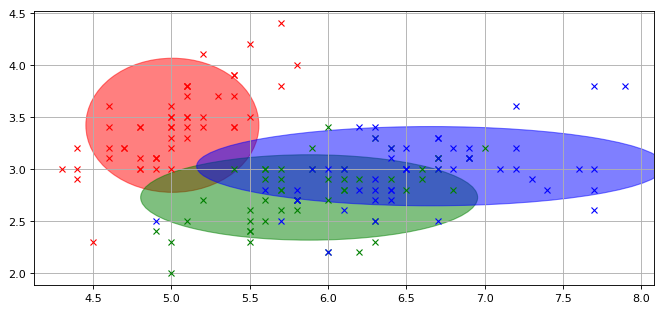

In [9]:
import warnings

from sklearn import datasets
from sklearn.cross_validation import StratifiedKFold
from sklearn.externals.six.moves import xrange
from sklearn.mixture import GMM

warnings.filterwarnings('ignore')


def make_ellipses(gmm, ax):
    for n, color in enumerate('rgb'):
        v, w = np.linalg.eigh(gmm._get_covars()[n][:2, :2])
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v *= 9
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

iris = datasets.load_iris()
X, y = iris.data, iris.target
skf = StratifiedKFold(iris.target, n_folds=5)
train_index, test_index = next(iter(skf))
n_classes = len(np.unique(y))

gmm = GMM(
    n_components=3,
    covariance_type='diag',
    init_params='wc',
    n_iter=500
)

# Since we have class labels for the training data, we can
# initialize the GMM parameters in a supervised manner.
gmm.means_ = np.array([X[y == i].mean(axis=0)
                              for i in xrange(n_classes)])
gmm.fit(X)

fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
n_classifiers = 2
h = plt.subplot(2, n_classifiers / 2, 1)
make_ellipses(gmm, h)

for n, color in enumerate('rgb'):
    data = X[y == n]
    plt.plot(data[:, 0], data[:, 1], 'x', color=color)
plt.grid(True)